In [1]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [2]:
# ฟังก์ชันตรวจจับ Drip และบันทึก Volume
def detect_drip_with_volume(data, window=12, threshold=-0.05, post_hours=[12, 24, 36, 48, 60, 72]):
    drips = []
    for i in range(len(data) - window - max(post_hours)):
        if drips and (data.index[i] - drips[-1]['start_time']).total_seconds() / 3600 < window:
            continue  # ข้ามถ้า Drip ใหม่เริ่มภายใน 12 ชั่วโมงจาก Drip ก่อนหน้า
        
        close_price = data['close'].iloc[i]
        low_price = data['low'].iloc[i:i+window].min()
        drip_pct = (low_price - close_price) / close_price
        if drip_pct <= threshold:
            # หา index และเวลาของ Low
            low_idx = data['low'].iloc[i:i+window].idxmin()
            low_time = low_idx
            # Volume ระหว่าง Drip (ใน 12 ชั่วโมง)
            volume_during = data['volume'].iloc[i:i+window].sum()
            # Volume หลัง Drip
            volume_after = {}
            for h in post_hours:
                try:
                    target_time = low_time + pd.Timedelta(hours=h)
                    start_idx = data.index.get_indexer([low_time], method='nearest')[0]
                    end_idx = data.index.get_indexer([target_time], method='nearest')[0]
                    volume_after[f'volume_{h}h'] = data['volume'].iloc[start_idx:end_idx+1].sum()
                except:
                    volume_after[f'volume_{h}h'] = np.nan
            drips.append({
                'start_time': data.index[i],
                'low_time': low_time,
                'close_price': close_price,
                'low_price': low_price,
                'drip_pct': drip_pct * 100,
                'volume_during': volume_during,
                'month': data.index[i].month,
                **volume_after
            })
            # ข้าม 12 ชั่วโมงเพื่อลด Overlap
            i += window - 1
    return pd.DataFrame(drips)

In [3]:
data = pd.read_pickle(os.path.abspath("../../crypto/datasets/preprocessed/BTCUSDT/1h/features.pkl"))

# ตรวจจับ Drip และบันทึก Volume
post_hours = [12, 24, 36, 48, 60, 72]
drips = detect_drip_with_volume(data)

In [4]:
# 1. การแจกแจงของ Volume ขณะเกิด Drip
print("\nSummary of Volume During Drip:")
volume_summary = {
    'Number of Drips': len(drips),
    'Mean Volume': drips['volume_during'].mean(),
    'Std Volume': drips['volume_during'].std(),
    'Min Volume': drips['volume_during'].min(),
    'Max Volume': drips['volume_during'].max(),
    'Median Volume': drips['volume_during'].median()
}
for key, value in volume_summary.items():
    print(f"{key}: {value:.2f}")


Summary of Volume During Drip:
Number of Drips: 710.00
Mean Volume: 45697.99
Std Volume: 50022.08
Min Volume: 225.94
Max Volume: 459224.98
Median Volume: 35780.28


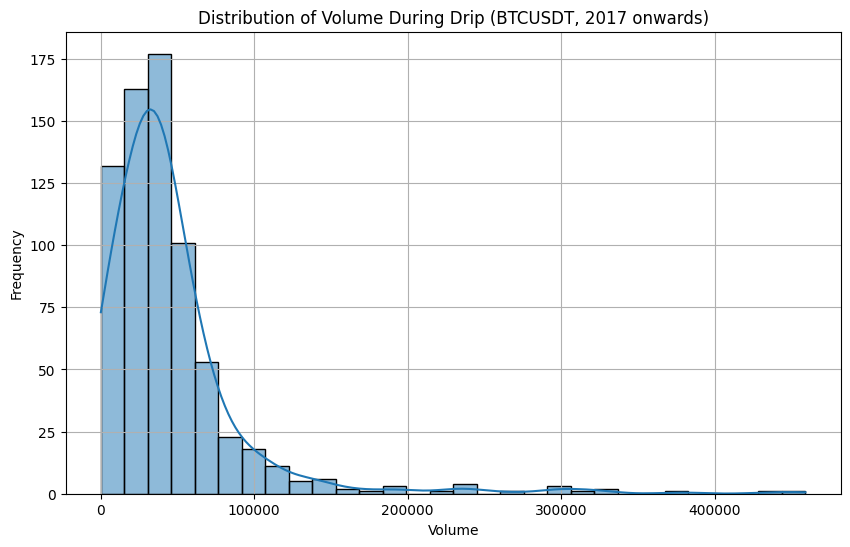

In [5]:
# สร้างฮิสโตแกรมของ Volume
plt.figure(figsize=(10, 6))
sns.histplot(drips['volume_during'].dropna(), bins=30, kde=True)
plt.title('Distribution of Volume During Drip (BTCUSDT, 2017 onwards)')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [6]:
# 2. ความสัมพันธ์ระหว่าง Volume และขนาด Drip
corr, p_value = stats.pearsonr(drips['volume_during'].dropna(), drips['drip_pct'].dropna())
print(f"\nCorrelation between Volume and Drip Size: corr={corr:.4f}, p-value={p_value:.4f}")
if p_value < 0.05:
    print("Significant correlation (p < 0.05)")
else:
    print("No significant correlation (p >= 0.05)")


Correlation between Volume and Drip Size: corr=-0.1626, p-value=0.0000
Significant correlation (p < 0.05)


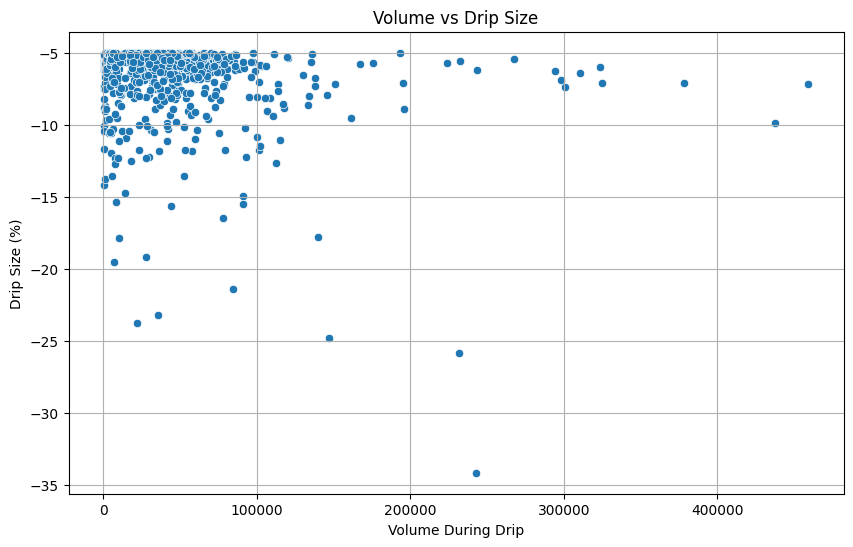

In [7]:
# Scatter Plot ของ Volume และ Drip Size
plt.figure(figsize=(10, 6))
sns.scatterplot(x='volume_during', y='drip_pct', data=drips)
plt.title('Volume vs Drip Size')
plt.xlabel('Volume During Drip')
plt.ylabel('Drip Size (%)')
plt.grid(True)
plt.show()

In [8]:
# 3. Volume หลัง Drip
volume_after_means = pd.DataFrame({
    h: drips[f'volume_{h}h'].mean() for h in post_hours
}, index=['Mean Volume']).T.reset_index()
volume_after_means.columns = ['Hours', 'Mean Volume']
print("\nMean Volume After Drip by Hours:")
print(volume_after_means.round(2))


Mean Volume After Drip by Hours:
   Hours  Mean Volume
0     12     48952.97
1     24     87849.86
2     36    121281.97
3     48    154929.51
4     60    185626.49
5     72    218036.44


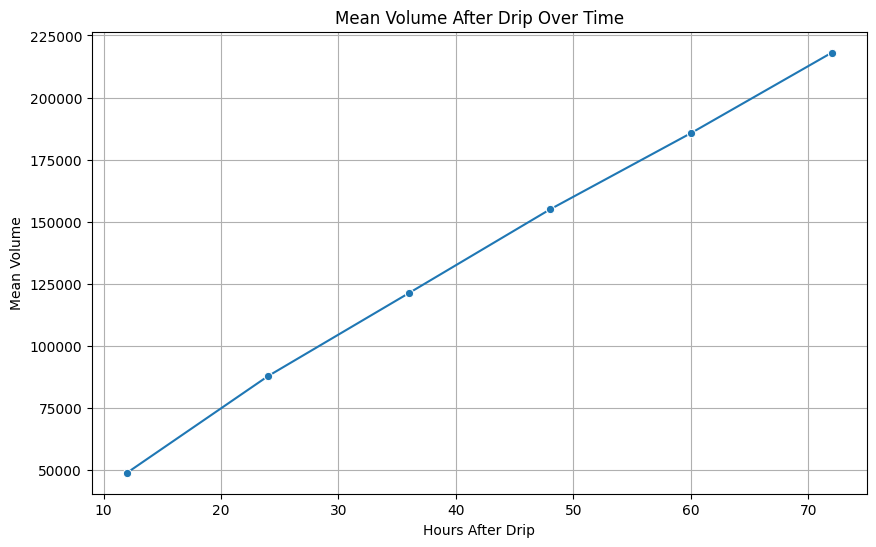

In [9]:
# สร้าง Line Plot ของ Volume หลัง Drip
plt.figure(figsize=(10, 6))
sns.lineplot(x='Hours', y='Mean Volume', data=volume_after_means, marker='o')
plt.title('Mean Volume After Drip Over Time')
plt.xlabel('Hours After Drip')
plt.ylabel('Mean Volume')
plt.grid(True)
plt.show()

In [10]:
# 4. การเปรียบเทียบ Volume ระหว่างเดือน
monthly_volume_means = drips.groupby('month')['volume_during'].mean().reset_index()
monthly_volume_means.columns = ['Month', 'Mean Volume']
print("\nMean Volume During Drip by Month:")
print(monthly_volume_means.round(2))


Mean Volume During Drip by Month:
    Month  Mean Volume
0       1     37706.12
1       2     41995.38
2       3     62024.33
3       4     43724.16
4       5     61923.95
5       6     54199.01
6       7     45806.37
7       8     37022.45
8       9     42889.29
9      10     28147.52
10     11     61393.33
11     12     23820.90


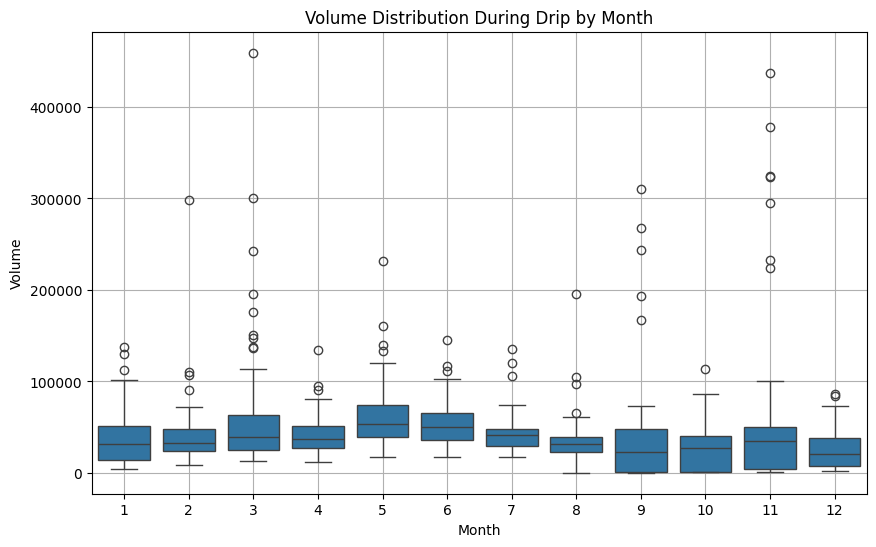

In [11]:
# Boxplot ของ Volume ตามเดือน
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='volume_during', data=drips)
plt.title('Volume Distribution During Drip by Month')
plt.xlabel('Month')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

In [12]:
# 5. One-Way ANOVA Test: Volume ระหว่างเดือน
if len(drips['month'].unique()) > 2:
    groups = [drips[drips['month'] == month]['volume_during'].dropna() for month in drips['month'].unique()]
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"\nOne-Way ANOVA Test for Volume: F={f_stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("Significant difference in mean Volume between months (p < 0.05)")
    else:
        print("No significant difference in mean Volume between months (p >= 0.05)")


One-Way ANOVA Test for Volume: F=4.4434, p-value=0.0000
Significant difference in mean Volume between months (p < 0.05)


In [13]:
# 6. T-Test: Volume ระหว่างคู่เดือน
print("\nT-Test Results for Volume (p-values for pairwise comparisons):")
t_test_results = []
month_pairs = list(itertools.combinations(drips['month'].unique(), 2))
for month1, month2 in month_pairs:
    group1 = drips[drips['month'] == month1]['volume_during'].dropna()
    group2 = drips[drips['month'] == month2]['volume_during'].dropna()
    if len(group1) > 1 and len(group2) > 1:
        t_stat, p_value = stats.ttest_ind(group1, group2)
        t_test_results.append({
            'Month Pair': f'{month1} vs {month2}',
            'T-Statistic': t_stat,
            'P-Value': p_value
        })
t_test_df = pd.DataFrame(t_test_results)
print(t_test_df.round(4))


T-Test Results for Volume (p-values for pairwise comparisons):
   Month Pair  T-Statistic  P-Value
0      8 vs 9      -0.4901   0.6253
1     8 vs 10       1.0531   0.2962
2     8 vs 11      -1.5479   0.1248
3     8 vs 12       2.6983   0.0080
4      8 vs 1      -0.1193   0.9052
..        ...          ...      ...
61     4 vs 6      -2.1632   0.0328
62     4 vs 7      -0.3626   0.7179
63     5 vs 6       1.3617   0.1757
64     5 vs 7       2.2042   0.0298
65     6 vs 7       1.4867   0.1404

[66 rows x 3 columns]


In [14]:
# 7. Tukey’s HSD Test: Volume ระหว่างทุกเดือน
if len(drips['month'].unique()) > 2:
    tukey = pairwise_tukeyhsd(endog=drips['volume_during'].dropna(), groups=drips['month'], alpha=0.05)
    print("\nTukey’s HSD Test Results for Volume:")
    print(tukey.summary())


Tukey’s HSD Test Results for Volume:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj     lower       upper    reject
---------------------------------------------------------------
     1      2    4289.258    1.0 -21265.9574  29844.4734  False
     1      3  24318.2057 0.0547   -220.4877   48856.899  False
     1      4   6018.0401 0.9999 -22640.8431  34676.9233  False
     1      5  24217.8308 0.0794  -1224.1199  49659.7815  False
     1      6  16492.8846 0.6323  -9420.3897   42406.159  False
     1      7   8100.2472 0.9996 -24149.9141  40350.4085  False
     1      8   -683.6687    1.0 -30500.5599  29133.2225  False
     1      9    5183.167    1.0 -22509.6786  32876.0127  False
     1     10  -9558.6054 0.9993 -45443.9141  26326.7033  False
     1     11  23687.2118 0.1114  -2226.0626  49600.4861  False
     1     12 -13885.2187 0.7586 -37839.4078  10068.9705  False
     2      3  20028.9477 0.3788  -6861.3141  46919.2095  False
  

In [15]:
# 8. F-Test: ความแปรปรวนของ Volume ระหว่างคู่เดือน
print("\nF-Test Results for Volume Variance:")
f_test_results = []
for month1, month2 in month_pairs:
    group1 = drips[drips['month'] == month1]['volume_during'].dropna()
    group2 = drips[drips['month'] == month2]['volume_during'].dropna()
    if len(group1) > 1 and len(group2) > 1:
        var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
        f_stat = var1 / var2 if var1 > var2 else var2 / var1
        df1, df2 = len(group1) - 1, len(group2) - 1
        p_value = 1 - stats.f.cdf(f_stat, df1, df2)
        f_test_results.append({
            'Month Pair': f'{month1} vs {month2}',
            'F-Statistic': f_stat,
            'P-Value': p_value
        })
f_test_df = pd.DataFrame(f_test_results)
print(f_test_df.round(4))


F-Test Results for Volume Variance:
   Month Pair  F-Statistic  P-Value
0      8 vs 9       4.2233   0.0000
1     8 vs 10       1.1717   0.3458
2     8 vs 11       8.0343   0.0000
3     8 vs 12       2.8598   0.0000
4      8 vs 1       1.3752   0.1055
..        ...          ...      ...
61     4 vs 6       1.1867   0.2636
62     4 vs 7       1.3044   0.2172
63     5 vs 6       2.0963   0.0019
64     5 vs 7       1.9071   0.0237
65     6 vs 7       1.0992   0.3932

[66 rows x 3 columns]


In [16]:
# 9. Levene’s Test: ความแปรปรวนของ Volume ระหว่างทุกเดือน
if len(drips['month'].unique()) > 2:
    groups = [drips[drips['month'] == month]['volume_during'].dropna() for month in drips['month'].unique()]
    stat, p_value = stats.levene(*groups)
    print(f"\nLevene’s Test for Volume Variance: stat={stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("Variances are significantly different (p < 0.05)")
    else:
        print("No significant difference in variances (p >= 0.05)")


Levene’s Test for Volume Variance: stat=3.9704, p-value=0.0000
Variances are significantly different (p < 0.05)
